In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import time
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split


## Helper functions!

In [87]:
def run_model(input, y):
    data = pd.concat([y,input], axis=1)
    formula = f'Withdraw ~ {" + ".join(input.columns)}'
    print(formula)
    model_full = ols(formula, data=data).fit()

    return model_full

# define function to compute test MSEs
def comp_test_mse(model, temp_data):
    predictions = model.predict(temp_data)
    mse_test = np.mean((temp_data['Withdraw']-predictions)**2)    
    return mse_test

## Read the data

In [88]:
# Read the data
data=pd.read_csv('ATM_sample.csv')
data.head()

# Define target variable
y = data['Withdraw']

# Define the input variables
X = data.drop(columns=['Withdraw'])

X.columns

Index(['Shops', 'ATMs', 'Downtown', 'Weekday', 'Center', 'High'], dtype='object')

In [89]:
# Standardise the continous data columns! 
columns_to_scale = ['ATMs', 'Shops']
X[columns_to_scale] = StandardScaler().fit_transform(X[columns_to_scale])
X.head()

,Shops,ATMs,Downtown,Weekday,Center,High
0,0.695292,0.561492,1,0,0,0
1,0.588459,0.561492,1,1,0,0
2,-1.543334,-1.616368,0,0,0,1
3,0.549611,0.289259,1,1,0,1
4,-1.526338,-1.071903,0,1,0,1


### Baseline Model for comparison

In [90]:
model = run_model(X, y)
model.summary()

Withdraw ~ Shops + ATMs + Downtown + Weekday + Center + High


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Withdraw   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 3.656e+05
Date:                Sun, 27 Oct 2024   Prob (F-statistic):               0.00
Time:                        11:49:33   Log-Likelihood:                -51380.
No. Observations:               22000   AIC:                         1.028e+05
Df Residuals:                   21993   BIC:                         1.028e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     81.5326      0.624    130.637      0.000      80.309      82.756
Shops         44.5379      0.405    110.062      0.000      43.745      45.331
ATMs          -3.7087      0.035   -106.982      0.000      -3.777      -3.641
Downtown     -36.1897      0.887    -40.781      0.000     -37.929     -34.450
Weekday       -3.5011      0.037    -93.806      0.000      -3.574      -3.428
Center         7.1931      0.056    129.352      0.000       7.084       7.302
High           0.9566      0.037     26.035      0.000       0.885       1.029
==============================================================================
Omnibus:                    17745.344   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           468940.833
Skew:                           3.781   Prob(JB):                         0.00
Kurtosis:                      24.316   Cond. No.                         107.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Alter the input columns (X) as you see fit

The following example adds combination variables split on downtown.

In [91]:
X_temp = X.drop(columns=['Downtown']).mul(X['Downtown'], axis=0).rename(columns={'Shops': "Shops_DT", 'ATMs': "ATMs_DT", 'Weekday': "Weekday__DT", 'Center': 'Center_DT', 'High': "High_DT"})  

In [92]:
X = pd.concat([X_temp,X], axis=1)
X.head()

,Shops_DT,ATMs_DT,Weekday__DT,Center_DT,High_DT,Shops,ATMs,Downtown,Weekday,Center,High
0,0.695292,0.561492,0,0,0,0.695292,0.561492,1,0,0,0
1,0.588459,0.561492,1,0,0,0.588459,0.561492,1,1,0,0
2,-0.000000,-0.000000,0,0,0,-1.543334,-1.616368,0,0,0,1
3,0.549611,0.289259,1,0,1,0.549611,0.289259,1,1,0,1
4,-0.000000,-0.000000,0,0,0,-1.526338,-1.071903,0,1,0,1


## Run the model with ALL the input variables

(optional step)
I like to do this so we can see the p value and potentially exclude some variables off the bat. 
This also gives us a base model to work with.

In [93]:
model = run_model(X, y)
print(model.summary()) 

Withdraw ~ Shops_DT + ATMs_DT + Weekday__DT + Center_DT + High_DT + Shops + ATMs + Downtown + Weekday + Center + High
                            OLS Regression Results                            
Dep. Variable:               Withdraw   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 2.257e+05
Date:                Sun, 27 Oct 2024   Prob (F-statistic):               0.00
Time:                        11:49:33   Log-Likelihood:                -50030.
No. Observations:               22000   AIC:                         1.001e+05
Df Residuals:                   21988   BIC:                         1.002e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
------------

## Best Subset selection!

AIC, BIC, test MSE all used. An interesting feature might be to change the train test split.

In [99]:
data = pd.concat([y,X], axis=1)

# # Train and test sets
# train = data.sample(frac=0.8, random_state=1)
# test = data[data.index.isin(train.index)==False]

X_train, X_test, y_train, y_test = train_test_split(
    X,                  # Features
    y,                  # Target variable
    test_size=0.2,      # 20% for testing, 80% for training
    random_state=42     # Set for reproducibility
)

train = pd.concat([y_train,X_train], axis=1)
test = pd.concat([y_test,X_test], axis=1)

# Initialize lists to store metrics
aic = []
bic = []
p = []
test_mse = []

# Start time measurement
start_time = time.time()

count = 1

# Null model with just the intercept
formula = 'Withdraw ~ 1'
model = ols(formula, data=data).fit()
aic.append(model.aic)
bic.append(model.bic)
test_mse.append(comp_test_mse(model, test))
p.append(1)

# Initialize best metrics with the null model
best_aic = model.aic
best_bic = model.bic
best_model_aic = formula
best_model_bic = formula
best_p_aic = 1
best_p_bic = 1
best_test_mse = test_mse[-1]
best_model_test_mse = formula

# Iterate over all combinations of predictors
for i in range(1, len(X.columns) + 1):

    # Reintialise best_train_mse for each i
    best_train_mse = np.inf

    for combo in itertools.combinations(X.columns, i):
        # Create the model formula
        formula = f'Withdraw ~ {" + ".join(combo)}'
        model = ols(formula, data=data).fit()
        train_mse = np.mean(model.resid ** 2)

        # Store the AIC, BIC, and number of parameters using append
        aic.append(model.aic)
        bic.append(model.bic)
        p.append(i + 1)
        
        # Update best AIC model if current model is better
        if model.aic < best_aic:
            best_model_aic = formula
            best_aic = model.aic
            best_p_aic = i + 1
        
        # Update best BIC model if current model is better
        if model.bic < best_bic:
            best_model_bic = formula
            best_bic = model.bic
            best_p_bic = i + 1
        
        count += 1

        #use train MSE to select the best set for a given number of predictors i
        if train_mse < best_train_mse:
            best_model_train_mse = formula
            best_model_fit_train_mse = model
            best_train_mse = train_mse

    # once the best set was found for given i compute test mse
    test_mse.append(comp_test_mse(best_model_fit_train_mse, test))

    # Update best model based on test_mse if current model is better
    if test_mse[-1] < best_test_mse:
        best_model_test_mse = best_model_train_mse
        best_test_mse = test_mse[-1]
        best_p_test = i + 1

    end_time = time.time()
    elapsed_time = end_time - start_time

# Output the best model
print(f"Best subset selection took {count} iterations and {elapsed_time:.2f} seconds. Best model based on each statistic is as follows (includes intercept):")
print(f"AIC={best_aic:.2f} with {best_p_aic} parameters:\n {best_model_aic}\n")
print(f"BIC={best_bic:.2f} with {best_p_bic} parameters:\n {best_model_bic}\n") 
print(f"test MSE: {best_test_mse:.2f} has {best_p_test} parameters:\n {best_model_test_mse}")

Best subset selection took 2048 iterations and 39.95 seconds. Best model based on each statistic is as follows (includes intercept):
AIC=100081.61 with 10 parameters:
 Withdraw ~ Shops_DT + Weekday__DT + Center_DT + Shops + ATMs + Downtown + Weekday + Center + High

BIC=100161.60 with 10 parameters:
 Withdraw ~ Shops_DT + Weekday__DT + Center_DT + Shops + ATMs + Downtown + Weekday + Center + High

test MSE: 5.61 has 12 parameters:
 Withdraw ~ Shops_DT + ATMs_DT + Weekday__DT + Center_DT + High_DT + Shops + ATMs + Downtown + Weekday + Center + High


<Axes: >

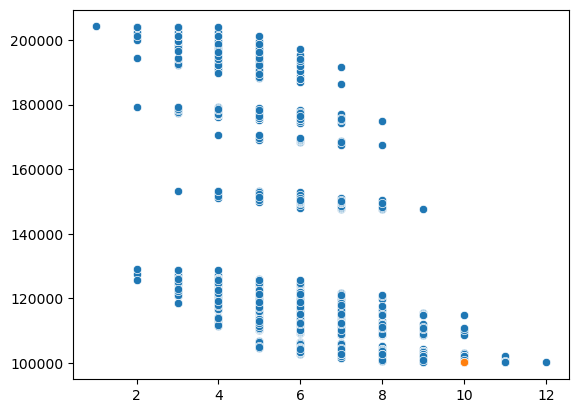

In [95]:
sns.scatterplot(x=p, y=aic)
sns.scatterplot(x=[best_p_aic], y=[best_aic]) # note here we plot just one point, but we need to pass is as list, hence the []

<Axes: >

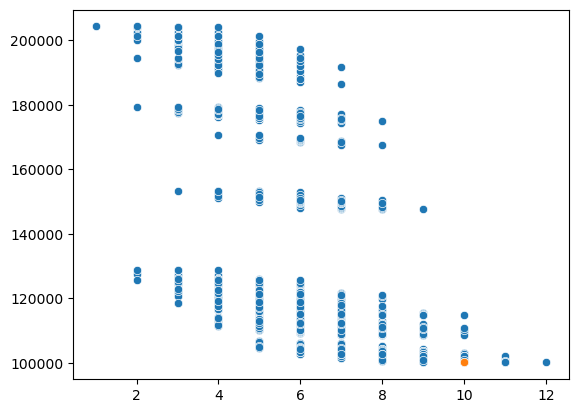

In [96]:
sns.scatterplot(x=p, y=bic)
sns.scatterplot(x=[best_p_bic], y=[best_bic]) # note here we plot just one point, but we need to pass is as list, hence the []

<Axes: >

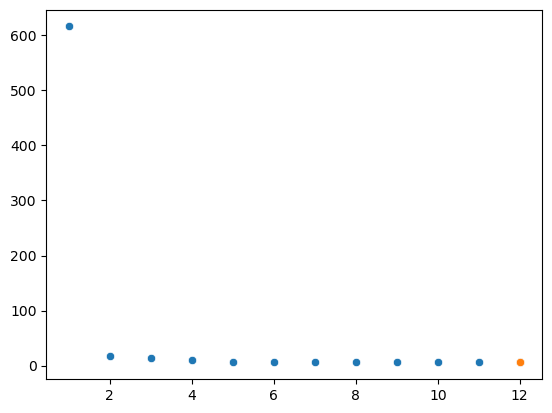

In [97]:
sns.scatterplot(x=range(1, len(X.columns) + 2),y=test_mse)
sns.scatterplot(x=[best_p_test], y=[best_test_mse]) # note here we plot just one point, but we need to pass is as list, hence the []

### TO DO: 

`from sklearn.feature_selection import RFECV`

Use this library to select features instead on cross validation

Note: I don't know how necessary this is given our time span. 
